# Some examples of how to fit MUSE spectra with the pPXF_wrapper package

In [1]:
#imports
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits, ascii
from astropy.table import Table

import importlib
import pPXF_wrapper.ppxf_wrapper as ppxf_wrapper


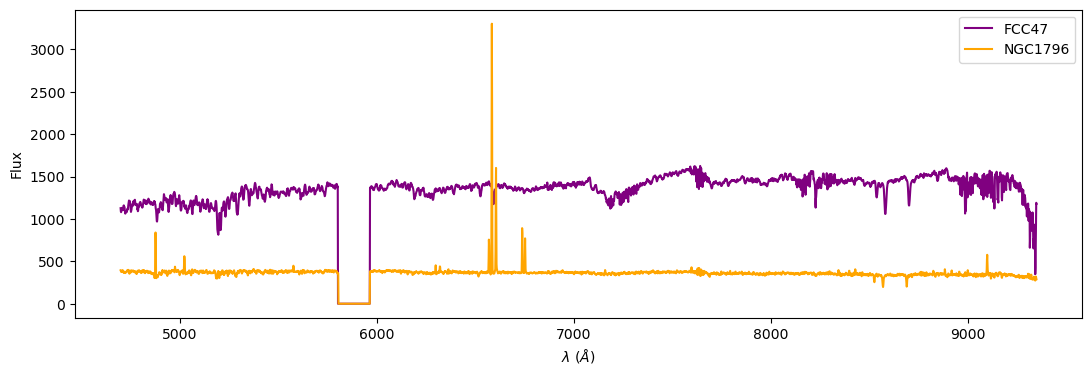

In [2]:
#First read in the example spectrum in /spectra/

file = './spectra/FCC47_MUSE_spec.dat'
spectab_FCC47 = ascii.read(file)

# This file contains the wavelength array ("wave"), the spectrum of the nuclear star cluster ("NSC_spec"), 
# and the corresponding variance spectrum ("NSC_spec_var")

#Plot it:
fig, ax = plt.subplots(figsize=[13, 4])
ax.plot(spectab_FCC47['wave'], spectab_FCC47['NSC_spec'], c='purple', label='FCC47')
ax.set_xlabel(r'$\lambda$ ($\AA$)')
ax.set_ylabel('Flux')

#let's add the other galaxy, NGC1796, a star forming dwarf
file = './spectra/NGC1796_MUSE_spec.dat'
spectab_NGC1796 = ascii.read(file)

ax.plot(spectab_NGC1796['wave'], spectab_NGC1796['NSC_spec'], c='orange', label='NGC1796')
ax.legend()

#As can be seen, this is MUSE AO data and the region around the NaD line is blocked

### Now we do the fitting, starting with the kinematics.
As both galaxies have the NaD region blocked due to the AO laser, we need to provide a line_mask file that masks out this region (and others that might contain sky residuals)

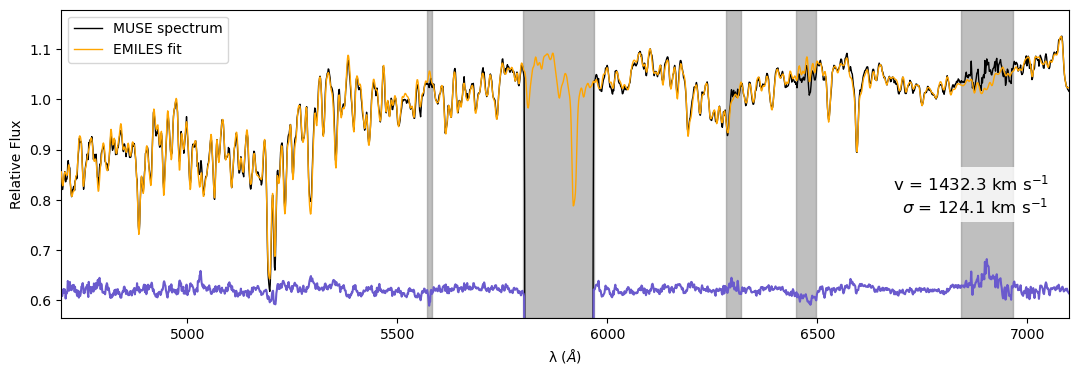

In [3]:
mask_file = './line_masks/line_mask_FCC47.dat'

#Now doing the fit
ppw_FCC47 = ppxf_wrapper.ppxf_wrapper(spectab_FCC47['wave'], #wavelength array
                                      spectab_FCC47['NSC_spec'], #flux array
                                      noise_spec = spectab_FCC47['NSC_spec_var'], #variance spectrum, optional, might fail if noise spectrum is not > 0 everywhere (e.g. in gap)
                                      mask_file=mask_file, #the line mask file, will ignore these regions
                                      vel = 1440, #guess for velocity
                                      lam_range=[4700, 7100], #wavelength range
                                      instrument='MUSE', #instrument
                                      ssp_models = 'EMILES', #ssp models for the fit, EMILES can be used for full MUSE spectrum, or XSL
                                      kin_only=True, #only kinematics
                                      degree=12, #additative polynomials (see ppxf documentation)
                                      moments=4, #kinematic moments to fit
                                      plot = True, #show plot
                                      plot_kin_title='FCC47_kin_fit.png', #title of plot if saved
                                      save_plots=False) #if true, will save


Emission lines included in gas templates:
['Hbeta' 'Halpha' '[SII]6716' '[SII]6731' 'HeI5876' '[OIII]5007_d'
 '[OI]6300_d' '[NII]6583_d']


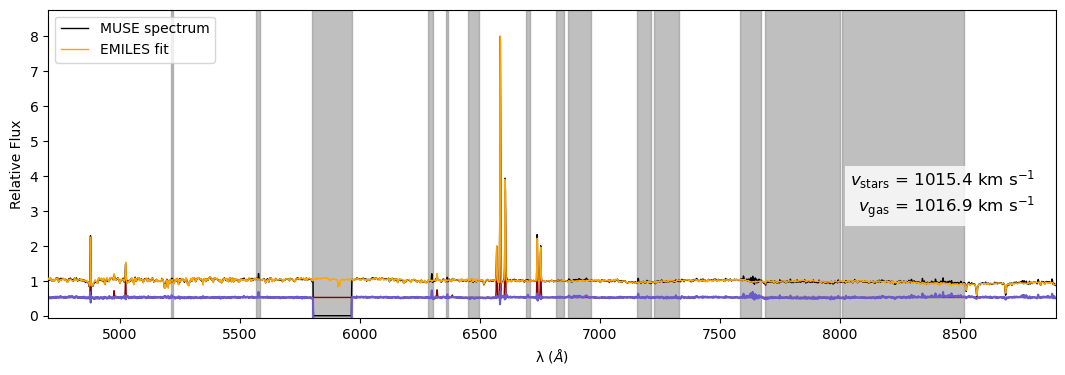

In [4]:
#or for NGC1796, here we need to also fit the gas using gas_fit=True

mask_file = './line_masks/line_mask_NGC1796.dat'

#Now doing the fit
ppw_NGC1796 = ppxf_wrapper.ppxf_wrapper(spectab_NGC1796['wave'], #wavelength array
                                      spectab_NGC1796['NSC_spec'], #flux array
                                      noise_spec = spectab_NGC1796['NSC_spec_var'], #variance spectrum, optional, might fail if noise spectrum is not > 0 everywhere (e.g. in gap)
                                      mask_file=mask_file, #the line mask file, will ignore these regions
                                      vel = 1000, #guess for velocity
                                      lam_range=[4700, 8900], #wavelength range
                                      instrument='MUSE', #instrument
                                      ssp_models = 'EMILES', #ssp models for the fit, EMILES can be used for full MUSE spectrum, or XSL
                                      kin_only=True, #only kinematics
                                      degree=12, #additative polynomials (see ppxf documentation)
                                      moments=4, #kinematic moments to fit
                                      gas_fit= True, #fit for gas (only works for MUSE at the moment)
                                      plot = True, #show plot
                                      plot_kin_title='FCC1796_kin_fit.png', #title of plot if saved
                                      save_plots=False) #if true, will save


### Now we fit for the stellar populations. 
This can be done in one go by setting kin_only = False, but would be even quicker now if we supply the templates from the kinematic fits as building the template library can take some seconds

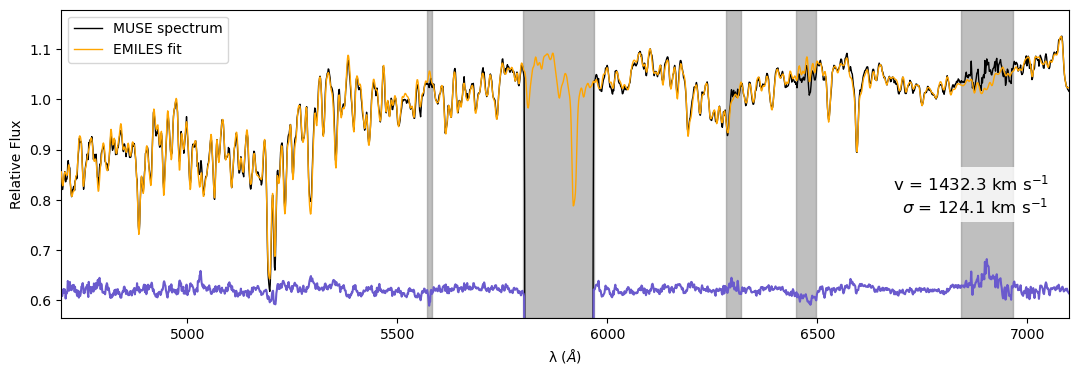

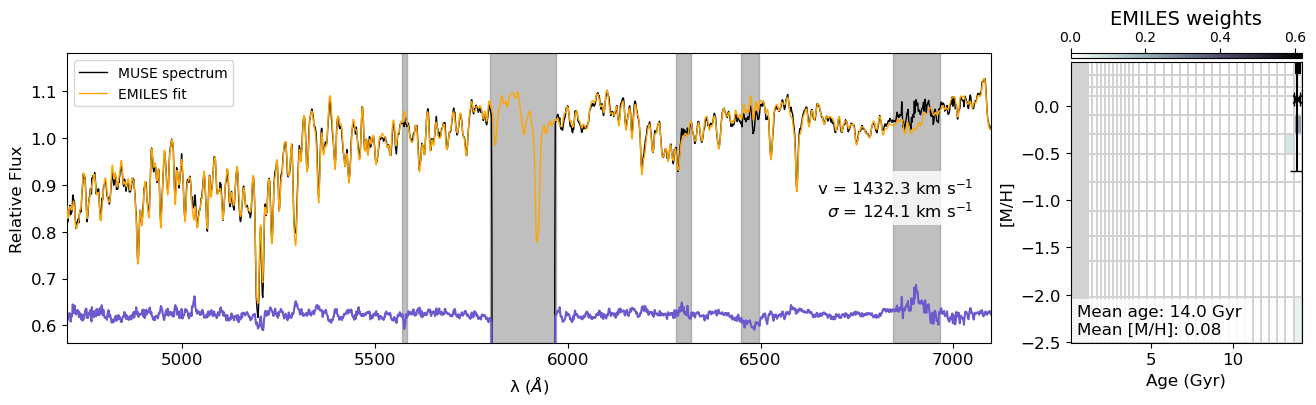

In [5]:
mask_file = './line_masks/line_mask_FCC47.dat'

#Now doing the fit
ppw_FCC47_pop = ppxf_wrapper.ppxf_wrapper(spectab_FCC47['wave'], #wavelength array
                                      spectab_FCC47['NSC_spec'], #flux array
                                      noise_spec = spectab_FCC47['NSC_spec_var'], #variance spectrum, optional, might fail if noise spectrum is not > 0 everywhere (e.g. in gap)
                                      mask_file=mask_file, #the line mask file, will ignore these regions
                                      vel = 1440, #guess for velocity
                                      lam_range=[4700, 7100], #wavelength range
                                      instrument='MUSE', #instrument
                                      ssp_models = 'EMILES', #ssp models for the fit, EMILES can be used for full MUSE spectrum, or XSL
                                      kin_only=False, #will do kinematics and then pops
                                      degree=12, #additative polynomials (see ppxf documentation)
                                      mdegree=8, #multiplicative polynomials
                                      moments=4, #kinematic moments to fit
                                      regul=0, #regularisation parameter, see ppxf documentation
                                      templates=ppw_FCC47.templates, #give templates libary to speed things up
                                      plot = True, #show plot
                                      plot_kin_title='FCC47_kin_fit.png',
                                      plot_pop_title='FCC47_pop_fit.png', #title of plot if saved
                                      save_plots=False) #if true, will save

### Finally, let's have a look at the ppw object and what it contains

In [6]:
# First things first, the fit results:
# each ppw contains the original ppxf output object (pp) that 
# contains the results as well as the weights of the best fitting models,
# see ppxf documentation for that
velocity = ppw_FCC47.pp.sol[0]
sigma = ppw_FCC47.pp.sol[1]
weights = ppw_FCC47.pp.weights

#for convenience, ppw itself also contains some of those results
velocity2 = ppw_FCC47.vel
sigma2 = ppw_FCC47.sig

print(velocity, velocity2, sigma, sigma2)

1432.2523890770947 1432.2523890770947 124.08420253123218 124.08420253123218


In [7]:
#stellar population results can be obtained from the pp.weights,
# but are also directly in the ppw object
age = ppw_FCC47_pop.age
metal = ppw_FCC47_pop.metal
print(age, metal)

13.9614374289065 0.07803778740416689


In [8]:
pp = ppw_FCC47.pp
templates = ppw_FCC47.templates

weights = pp.weights[~pp.gas_component].reshape(
templates.n_ages, templates.n_metal)/pp.weights[~pp.gas_component].sum()
mean_age, mean_metal = templates.mean_age_metal(weights, quiet=True)

xgrid = templates.age_grid
ygrid = templates.metal_grid
mean_age = np.sum(weights*xgrid)/np.sum(weights)
mean_metal = np.sum(weights*ygrid)/np.sum(weights)

std_age = np.sqrt(np.sum(weights)/(np.sum(weights)**2 - np.sum(weights**2))
                    * np.sum(weights * (xgrid - mean_age)**2))
std_metal = np.sqrt(np.sum(weights)/(np.sum(weights)**2 - np.sum(weights**2))
                        * np.sum(weights * (ygrid - mean_metal)**2))

print(mean_age, mean_metal)

14.0 0.08735095671645288


In [9]:
ppw_FCC47.templates